In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch
print(torch.cuda.is_available())

True


In [7]:
import kagglehub

path = kagglehub.dataset_download("soumikrakshit/anime-faces")


print("Đường dẫn tới tệp dữ liệu:", path)

100%|██████████| 441M/441M [00:03<00:00, 152MB/s]

Extracting files...


Đường dẫn tới tệp dữ liệu: /root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1


In [8]:
import os
# In ra danh sách các tệp trong thư mục
print(os.listdir(path))

['data']


In [9]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt

import csv
import torch
import kagglehub
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets as torch_dataset
from torchvision.utils import make_grid
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from torch.distributions.uniform import Uniform

Đường dẫn tới tệp dữ liệu: /root/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


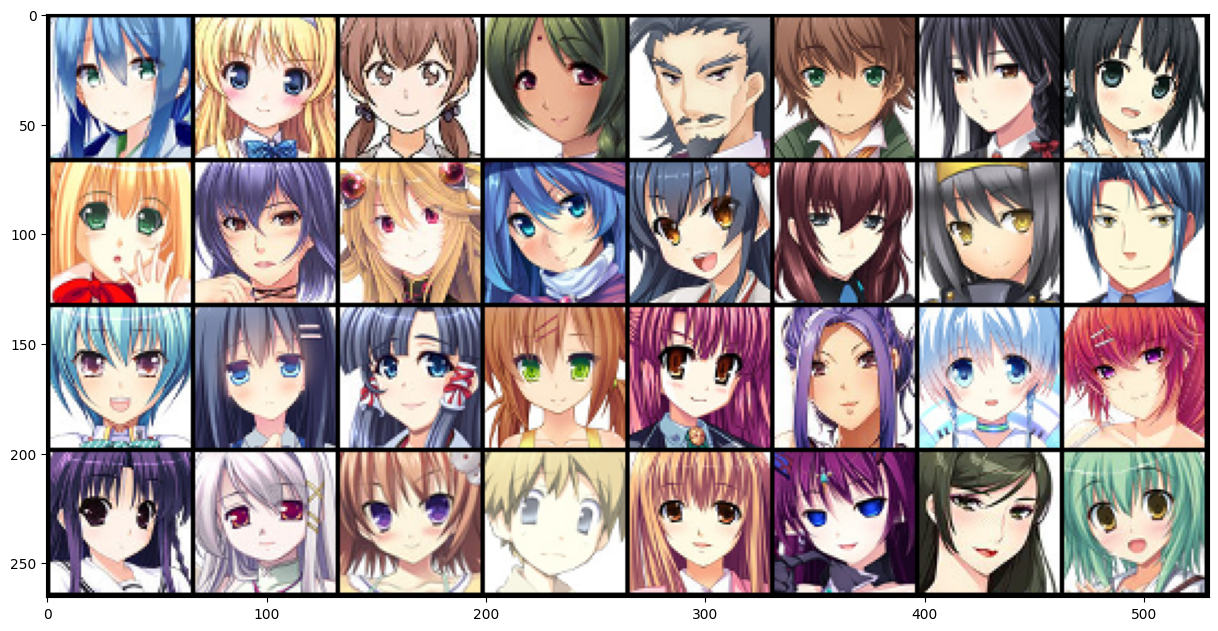

In [10]:
import kagglehub

path = kagglehub.dataset_download("soumikrakshit/anime-faces")

print("Đường dẫn tới tệp dữ liệu:", path)
img_size = 64
data_dir = path
data_transforms = T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

anime_dataset = torch_dataset.ImageFolder(root=data_dir, transform=data_transforms)
#btach size =128
dataloader = DataLoader(dataset=anime_dataset, batch_size=128, shuffle=True, num_workers=4)

img_batch = next(iter(dataloader))[0]
combine_img = make_grid(img_batch[:32], normalize=True, padding=2).permute(1,2,0)
plt.figure(figsize=(15,15))
plt.imshow(combine_img)
plt.show()

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def Conv(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
    return nn.Sequential(
        nn.Conv2d(
            n_input, n_output,
            kernel_size=k_size,
            stride=stride,
            padding=padding, bias=False),
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(p=0.2, inplace=False))

def Deconv(n_input, n_output, k_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(
            n_input, n_output,
            kernel_size=k_size,
            stride=stride, padding=padding,
            bias=False),
        nn.BatchNorm2d(n_output),
        nn.ReLU(inplace=True))

class Generator(nn.Module):
    def __init__(self, z=128, nc=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            Deconv(z, nc*8, 4,1,0),
            Deconv(nc*8, nc*4, 4,2,1),
            Deconv(nc*4, nc*2, 4,2,1),
            Deconv(nc*2, nc, 4,2,1),
            nn.ConvTranspose2d(nc,3, 4,2,1,bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.net(input)

class Discriminator(nn.Module):
    def __init__(self, nc=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                3, nc,
                kernel_size=4,
                stride=2,
                padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            Conv(nc, nc*2, 4,2,1),
            Conv(nc*2, nc*4, 4,2,1),
            Conv(nc*4, nc*8, 4,2,1),
            nn.Conv2d(nc*8, 1,4,1,0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        return self.net(input)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dis_model = Discriminator()
gen_model = Generator()

# Tải trọng số vào mô hình

import os

# Đường dẫn đến tệp cần kiểm tra
file_path = "/content/gen_model.pth"
file_path2 = "/content/dis_model.pth"


# Kiểm tra tệp có tồn tại không
if os.path.exists(file_path):
    print(f"Tệp '{file_path}' tồn tại.")
    gen_model.load_state_dict(torch.load('gen_model.pth'))
else:
    print(f"Tệp '{file_path}' không tồn tại.")


if os.path.exists(file_path2):
    print(f"Tệp '{file_path2}' tồn tại.")
    dis_model.load_state_dict(torch.load('dis_model.pth'))
else:
    print(f"Tệp '{file_path2}' không tồn tại.")



#gen_model.load_state_dict(torch.load('gen_model.pth'))
#dis_model.load_state_dict(torch.load('dis_model.pth'))

gen_model.apply(weights_init)
dis_model.apply(weights_init)

dis_model.to(device)
gen_model.to(device)


print('init model')
#print(gen_model)
#print(dis_model)

Đang sử dụng thiết bị: cuda
Tệp '/content/gen_model.pth' không tồn tại.
Tệp '/content/dis_model.pth' không tồn tại.
init model


In [12]:
from torch import optim

real_label = 1.
fake_label = 0.
lr = 0.0002
beta1 = 0.5

criterion = nn.BCELoss()
optim_D = optim.Adam(dis_model.parameters(), lr=lr, betas=(beta1, 0.999))
optim_G = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta1, 0.999))

[0/5][0/337]	Loss_D: 0.5547	Loss_G: 4.0087	D(x): 0.8288	D(G(z)): 0.1345 / 0.0318
[0/5][300/337]	Loss_D: 0.6637	Loss_G: 5.6324	D(x): 0.8840	D(G(z)): 0.2511 / 0.0051
[1/5][0/337]	Loss_D: 0.6886	Loss_G: 6.4440	D(x): 0.8624	D(G(z)): 0.2548 / 0.0029
[1/5][300/337]	Loss_D: 0.5791	Loss_G: 3.8463	D(x): 0.7784	D(G(z)): 0.0555 / 0.0384
[2/5][0/337]	Loss_D: 0.4707	Loss_G: 4.7873	D(x): 0.8439	D(G(z)): 0.0419 / 0.0161
[2/5][300/337]	Loss_D: 0.4844	Loss_G: 4.0083	D(x): 0.8490	D(G(z)): 0.0642 / 0.0277


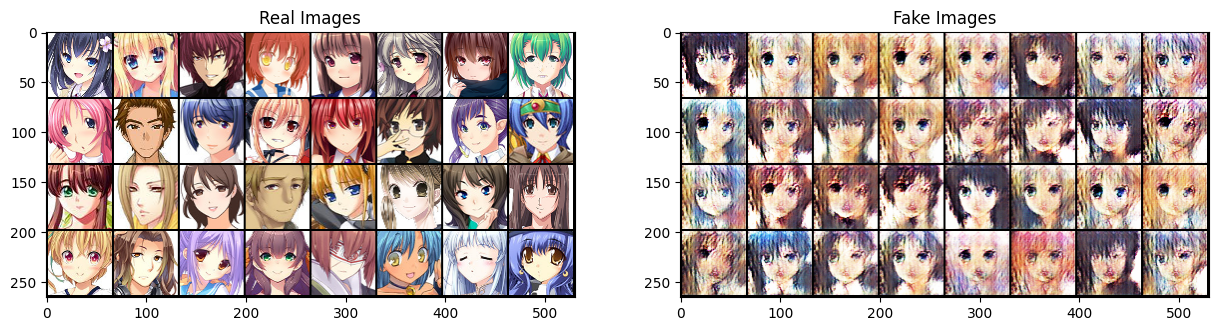

[3/5][0/337]	Loss_D: 1.8013	Loss_G: 4.3592	D(x): 0.3261	D(G(z)): 0.0006 / 0.0243
[3/5][300/337]	Loss_D: 2.2397	Loss_G: 8.4623	D(x): 0.9811	D(G(z)): 0.7536 / 0.0007
[4/5][0/337]	Loss_D: 0.5585	Loss_G: 3.7661	D(x): 0.8113	D(G(z)): 0.0888 / 0.0413
[4/5][300/337]	Loss_D: 0.5071	Loss_G: 5.7237	D(x): 0.9279	D(G(z)): 0.1590 / 0.0056


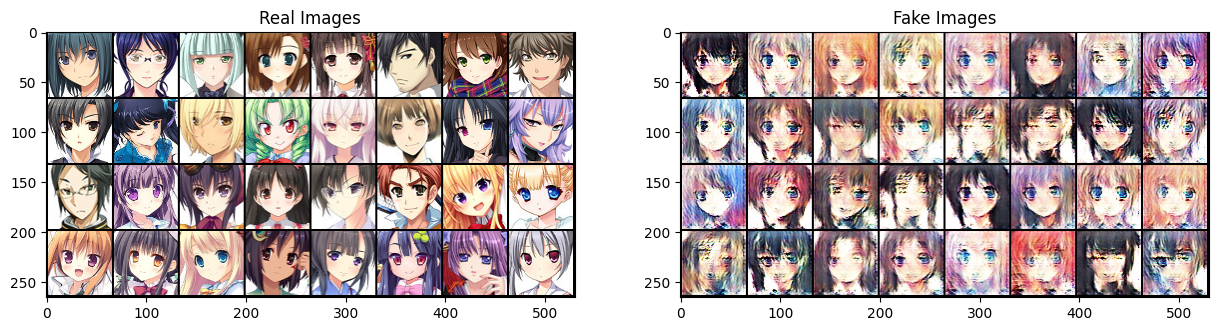

In [17]:
import csv
import matplotlib.pyplot as plt
from torch.distributions.uniform import Uniform
from torchvision.utils import make_grid

# Tạo tệp CSV để lưu các thông số
csv_filename = 'training_logs.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Loss_D', 'Loss_G', 'D(x)', 'D(G(z))_fake', 'D(G(z))_real'])

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 1
epoch_nb = 5
fixed_noise = torch.randn(32, 128, 1, 1, device=device)

for epoch in range(epoch_nb):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0
    epoch_D_x = 0.0
    epoch_D_G_z1 = 0.0
    epoch_D_G_z2 = 0.0
    batch_count = 0

    for i, data in enumerate(dataloader):
        # Train Discriminator
        ## Train with real image
        dis_model.zero_grad()
        real_img = data[0].to(device)
        bz = real_img.size(0)

        # Label smoothing
        label = Uniform(0.9, 1.0).sample((bz,)).to(device)
        output = dis_model(real_img).view(-1)
        error_real = criterion(output, label)
        error_real.backward()
        D_x = output.mean().item()

        ## Train with fake image
        noise = torch.randn(bz, 128, 1, 1, device=device)
        fake_img = gen_model(noise)
        label = Uniform(0., 0.05).sample((bz,)).to(device)
        output = dis_model(fake_img.detach()).view(-1)
        error_fake = criterion(output, label)
        error_fake.backward()
        D_G_z1 = output.mean().item()
        error_D = error_real + error_fake
        optim_D.step()

        ## Train Generator
        gen_model.zero_grad()
        label = Uniform(0.95, 1.0).sample((bz,)).to(device)
        output = dis_model(fake_img).view(-1)
        error_G = criterion(output, label)
        error_G.backward()
        optim_G.step()
        D_G_z2 = output.mean().item()

        # Cộng dồn các giá trị cho từng epoch
        epoch_loss_D += error_D.item()
        epoch_loss_G += error_G.item()
        epoch_D_x += D_x
        epoch_D_G_z1 += D_G_z1
        epoch_D_G_z2 += D_G_z2
        batch_count += 1

        if i % 300 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epoch_nb, i, len(dataloader),
                     error_D.item(), error_G.item(), D_x, D_G_z1, D_G_z2))

        if epoch > 1:
            if (iters % 1000 == 0) or ((epoch == epoch_nb-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake_img = gen_model(fixed_noise).detach().cpu()
                fake_img_grid = make_grid(fake_img, padding=2, normalize=True)

                # Lấy ảnh thật tương ứng với batch đầu tiên
                real_img_grid = make_grid(real_img[:32].detach().cpu(), padding=2, normalize=True)

                img_list.append(fake_img_grid)
                real_img_list.append(real_img_grid)

                plt.figure(figsize=(15, 15))

                # Hiển thị ảnh thật
                plt.subplot(1, 2, 1)
                plt.title("Real Images")
                plt.imshow(real_img_list[-1].permute(1, 2, 0))

                # Hiển thị ảnh giả
                plt.subplot(1, 2, 2)
                plt.title("Fake Images")
                plt.imshow(img_list[-1].permute(1, 2, 0))

                plt.show()

        iters += 1

    # Ghi thông số vào CSV sau mỗi epoch
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch,
                         epoch_loss_D / batch_count,
                         epoch_loss_G / batch_count,
                         epoch_D_x / batch_count,
                         epoch_D_G_z1 / batch_count,
                         epoch_D_G_z2 / batch_count])


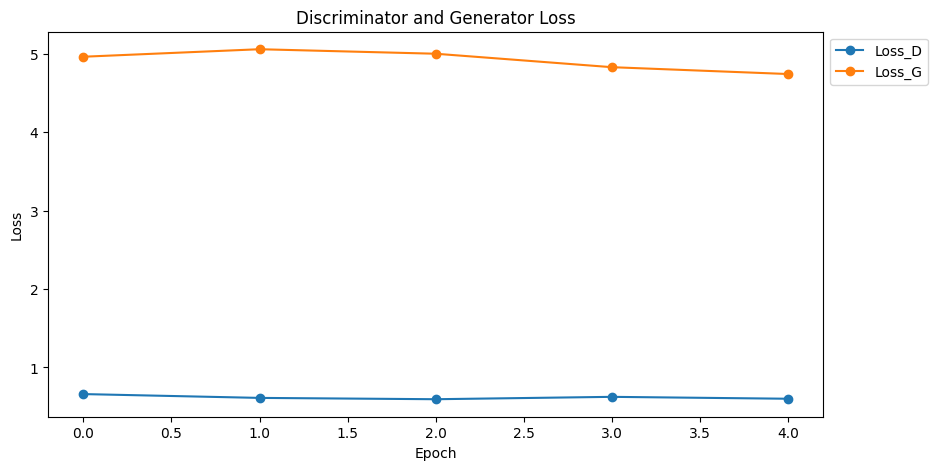

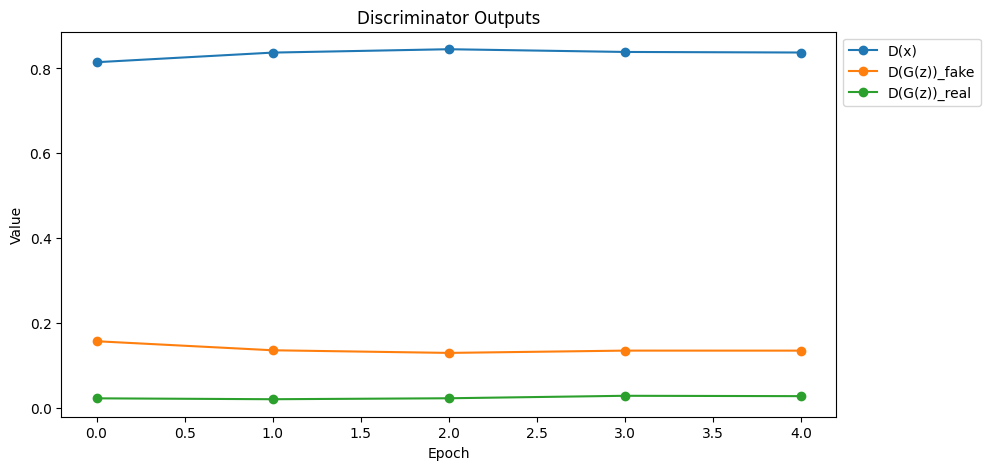

In [23]:
# Vẽ biểu đồ từ CSV theo Epoch
import pandas as pd
import matplotlib.pyplot as plt
csv_filename = 'training_logs.csv'
# Đọc dữ liệu từ tệp CSV
logs = pd.read_csv(csv_filename)

# Vẽ biểu đồ Loss_D và Loss_G
plt.figure(figsize=(10, 5))
plt.plot(logs['Epoch'], logs['Loss_D'], label='Loss_D', marker='o')
plt.plot(logs['Epoch'], logs['Loss_G'], label='Loss_G', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Discriminator and Generator Loss')
plt.grid(False)
plt.show()

# Vẽ biểu đồ D(x), D(G(z))_fake, D(G(z))_real
plt.figure(figsize=(10, 5))
plt.plot(logs['Epoch'], logs['D(x)'], label='D(x)', marker='o')
plt.plot(logs['Epoch'], logs['D(G(z))_fake'], label='D(G(z))_fake', marker='o')
plt.plot(logs['Epoch'], logs['D(G(z))_real'], label='D(G(z))_real', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Discriminator Outputs')
plt.grid(False)
plt.show()

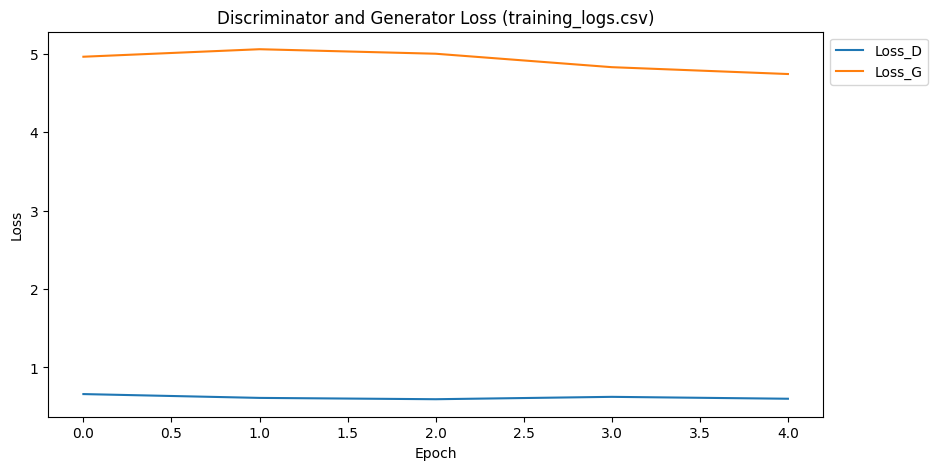

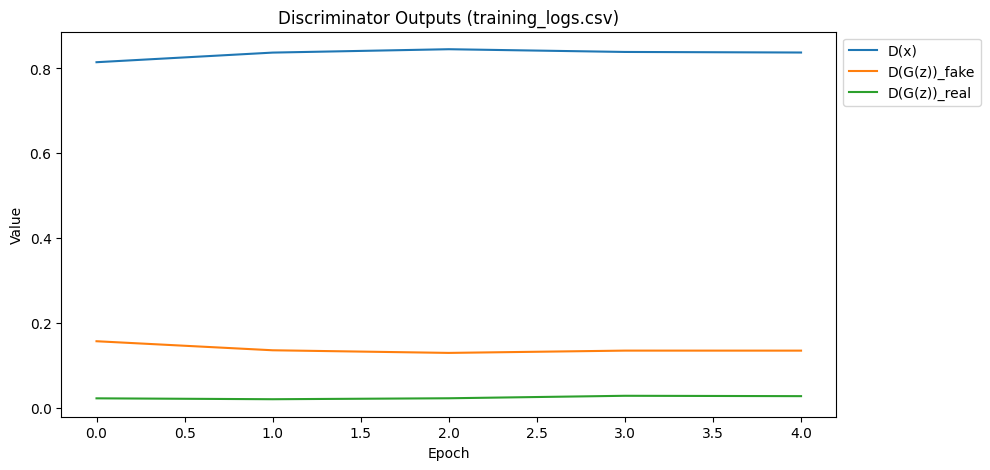

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Danh sách tên tệp CSV
csv_files = ['training_logs.csv']

for csv_file in csv_files:
    logs = pd.read_csv(csv_file)

    # Vẽ Loss theo Epoch
    plt.figure(figsize=(10, 5))
    plt.plot(logs['Epoch'], logs['Loss_D'], label='Loss_D', linestyle='-')
    plt.plot(logs['Epoch'], logs['Loss_G'], label='Loss_G', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f'Discriminator and Generator Loss ({csv_file})')
    plt.grid(False)
    plt.show()

    # Vẽ Scores theo Epoch
    plt.figure(figsize=(10, 5))
    plt.plot(logs['Epoch'], logs['D(x)'], label='D(x)', linestyle='-')
    plt.plot(logs['Epoch'], logs['D(G(z))_fake'], label='D(G(z))_fake', linestyle='-')
    plt.plot(logs['Epoch'], logs['D(G(z))_real'], label='D(G(z))_real', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f'Discriminator Outputs ({csv_file})')
    plt.grid(False)
    plt.show()


In [ ]:
# Lưu mô hình và optimizer
torch.save(gen_model.state_dict(), 'gen_model.pth')
torch.save(dis_model.state_dict(), 'dis_model.pth')
#torch.save(optim_G.state_dict(), 'optim_G.pth')
#torch.save(optim_D.state_dict(), 'optim_D.pth')

print("Models and optimizers saved!")

Models and optimizers saved!


<ipython-input-24-ad7ea9699b38>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load('gen_model.pth'))
<ipython-input-24-ad7ea9699b38>:6: Fu

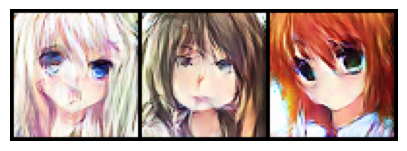

In [ ]:
gen_model = Generator()  # Tạo một đối tượng mô hình Generator
dis_model = Discriminator()  # Tạo một đối tượng mô hình Discriminator

# Tải trọng số vào mô hình
gen_model.load_state_dict(torch.load('gen_model.pth'))
dis_model.load_state_dict(torch.load('dis_model.pth'))

# Đặt mô hình ở chế độ đánh giá (eval mode)
gen_model.eval()
dis_model.eval()

# Tạo noise để sinh ảnh giả
noise = torch.randn(32, 100, 1, 1)  # Batch size = 1, vector noise kích thước 100
fake_img = gen_model(noise)

# Hiển thị ảnh giả được tạo
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

fake_img = make_grid(fake_img, padding=2, normalize=True)
plt.figure(figsize=(5, 5))
plt.imshow(fake_img.permute(1, 2, 0))  # Chuyển thứ tự kênh để hiển thị
plt.axis('off')
plt.show()

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Tạo một đối tượng mô hình Generator và Discriminator
gen_model = Generator()  # Định nghĩa class Generator của bạn
dis_model = Discriminator()  # Định nghĩa class Discriminator của bạn

# Tải trọng số vào mô hình
gen_model.load_state_dict(torch.load('gen_model.pth'))
dis_model.load_state_dict(torch.load('dis_model.pth'))

# Đặt mô hình ở chế độ đánh giá (eval mode)
gen_model.eval()
dis_model.eval()


# Lấy ảnh thật tương ứng với batch đầu tiên
real_img_grid = make_grid(real_img[:32].detach().cpu(), padding=2, normalize=True)

# Tạo noise để sinh ảnh giả
noise = torch.randn(1, 100, 1, 1)  # Batch size = 1, vector noise kích thước 100
fake_img = gen_model(noise).detach().cpu()

# Hiển thị ảnh giả và ảnh thật cạnh nhau
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Hiển thị ảnh thật
real_img_grid = make_grid(real_img, padding=2, normalize=True)
axs[0].imshow(real_img_grid.permute(1, 2, 0))  # Chuyển thứ tự kênh để hiển thị
axs[0].set_title("Ảnh thật")
axs[0].axis('off')

# Hiển thị ảnh giả
fake_img_grid = make_grid(fake_img, padding=2, normalize=True)
axs[1].imshow(fake_img_grid.permute(1, 2, 0))  # Chuyển thứ tự kênh để hiển thị
axs[1].set_title("Ảnh giả")
axs[1].axis('off')

plt.show()
